In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import numpy as np
from glob import glob
from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import random

torch.manual_seed(2025)

# Paths
orig_root = "/content/drive/MyDrive/Colab Notebooks/Hybrid/Dataset_BUSI_with_GT"

# Only Base transform (no augmentation)
base_tfs = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CLAHEDatasetOversampled(Dataset):
    def __init__(self, root, base_transform=None, samples_per_class=1000, im_exts=[".png", ".jpg", ".jpeg", ".bmp"]):
        self.base = base_transform
        self.samples_per_class = samples_per_class
        self.orig_paths = []

        for ext in im_exts:
            self.orig_paths.extend(glob(f"{root}/*/*{ext}"))

        self.classes = sorted({os.path.basename(os.path.dirname(p)) for p in self.orig_paths})
        self.cls2idx = {c: i for i, c in enumerate(self.classes)}

        # Collect classwise paths
        self.classwise_paths = {cls: [] for cls in self.classes}
        for path in self.orig_paths:
            class_name = os.path.basename(os.path.dirname(path))
            self.classwise_paths[class_name].append(path)

        # Oversample to `samples_per_class` per class
        self.samples = []
        for cls in self.classes:
            paths = self.classwise_paths[cls]
            if len(paths) >= samples_per_class:
                sampled = random.sample(paths, samples_per_class)
            else:
                sampled = random.choices(paths, k=samples_per_class)
            self.samples.extend([(p, self.cls2idx[cls]) for p in sampled])
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def clahe_apply(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Moderate CLAHE
        img = clahe.apply(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        return Image.fromarray(img)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        img = self.clahe_apply(img)
        img = self.base(img)
        return img, label

# Instantiate dataset with oversampling
dataset = CLAHEDatasetOversampled(orig_root, base_transform=base_tfs, samples_per_class=1000)

# Train/Val/Test split
tr_len = int(len(dataset) * 0.7)
vl_len = int(len(dataset) * 0.1)
ts_len = len(dataset) - tr_len - vl_len
tr_ds, vl_ds, ts_ds = torch.utils.data.random_split(dataset, [tr_len, vl_len, ts_len])

# Dataloaders
tr_dl = DataLoader(tr_ds, batch_size=16, shuffle=True, num_workers=4)
val_dl = DataLoader(vl_ds, batch_size=16, shuffle=False, num_workers=4)
ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=4)

# Class dictionary
classes = dataset.cls2idx
cls_counts = {c: 1000 for c in dataset.classes}

print("Train batches:", len(tr_dl), "Val batches:", len(val_dl), "Test batches:", len(ts_dl))
print("Classes:", classes)
print("Class image counts after oversampling:", cls_counts)


Train batches: 132 Val batches: 19 Test batches: 600
Classes: {'benign': 0, 'malignant': 1, 'normal': 2}
Class image counts after oversampling: {'benign': 1000, 'malignant': 1000, 'normal': 1000}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


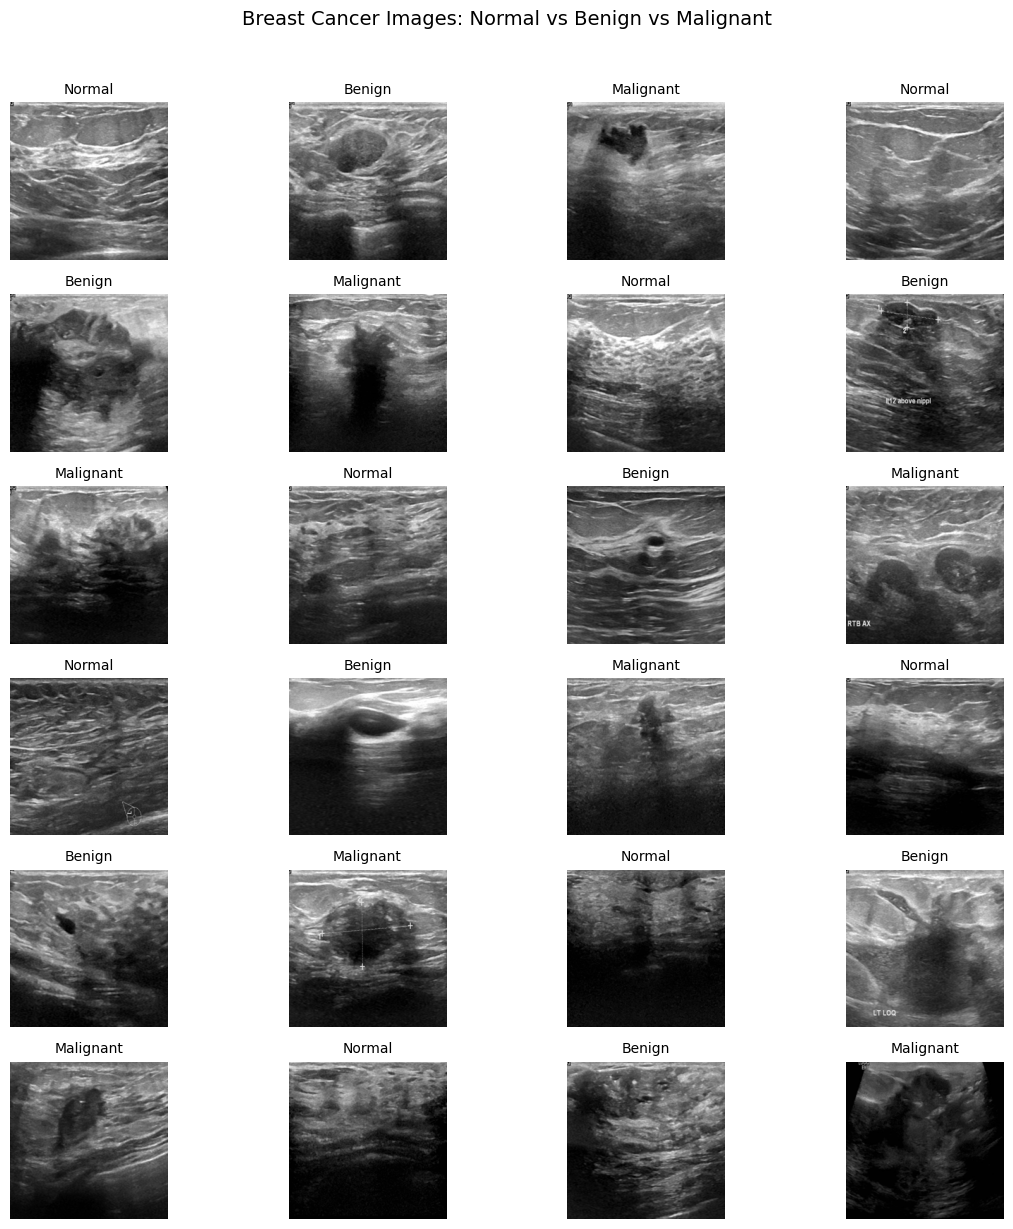

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

def plot_combined_images(root_dir, n_images=8, image_size=(224, 224), figsize=(12, 12)):
    # Corrected folder names (lowercase)
    class_paths = {
        'Normal': os.path.join(root_dir, "normal"),
        'Benign': os.path.join(root_dir, "benign"),
        'Malignant': os.path.join(root_dir, "malignant")
    }

    class_images = {}
    for class_name, path in class_paths.items():
        if not os.path.exists(path):
            print(f"Warning: Folder {path} does not exist.")
            continue
        images = []
        for f in os.listdir(path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                images.append(os.path.join(path, f))
        if len(images) > 0:
            class_images[class_name] = random.sample(images, min(n_images, len(images)))
        else:
            class_images[class_name] = []

    plt.figure(figsize=figsize)

    for i in range(n_images * 3):
        plt.subplot(6, 4, i+1)  # 6x4 grid
        class_list = list(class_images.keys())
        class_name = class_list[i % 3]
        img_idx = i // 3

        if img_idx < len(class_images[class_name]):
            img = Image.open(class_images[class_name][img_idx])
            img = img.resize(image_size)  # Resize to fixed size
            plt.imshow(img)
            plt.title(class_name, fontsize=10)
        else:
            plt.imshow(np.zeros((image_size[0], image_size[1], 3)))
            plt.title("No image", fontsize=8)
        plt.axis('off')

    plt.suptitle("Breast Cancer Images: Normal vs Benign vs Malignant", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/Hybrid/Dataset_BUSI_with_GT/combined_images.png', dpi=300, bbox_inches='tight')
    plt.show()

# Path to your dataset
root_path = "/content/drive/MyDrive/Colab Notebooks/Hybrid/Dataset_BUSI_with_GT"

plot_combined_images(root_path)


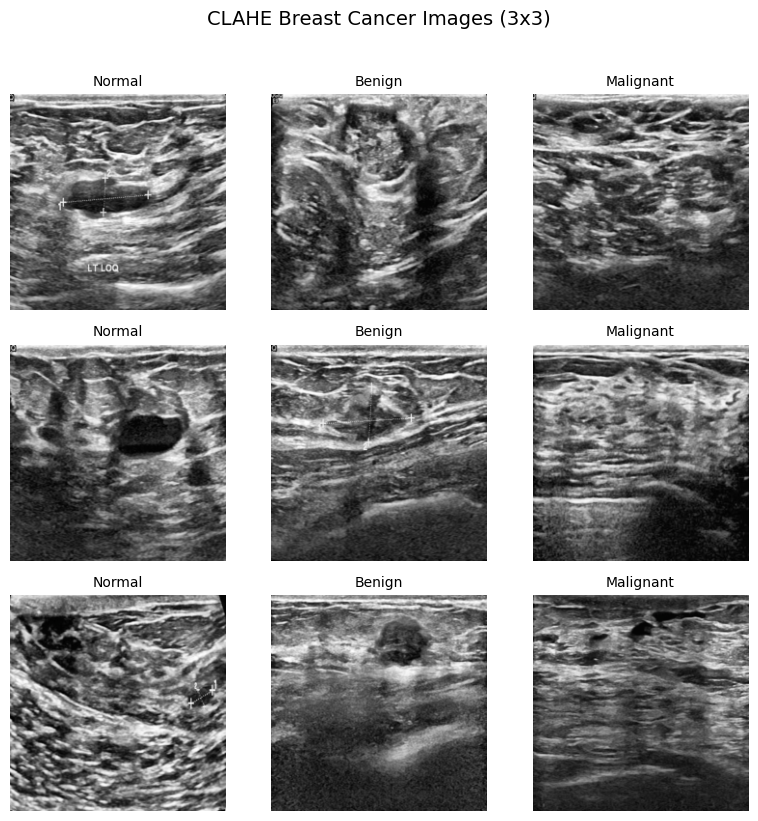

In [4]:
def plot_clahe_augmented_images(dataset, n_images=3, figsize=(8, 8)):
    samples = {0: [], 1: [], 2: []}

    for i in range(len(dataset)):
        img, label = dataset[i]
        if len(samples[label]) < n_images:
            samples[label].append(img)
        if all(len(v) >= n_images for v in samples.values()):
            break

    plt.figure(figsize=figsize)

    denormalize = T.Compose([
        T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
    ])

    labels_map = {0: 'Normal', 1: 'Benign', 2: 'Malignant'}
    for i in range(n_images * 3):
        plt.subplot(3, 3, i+1)
        label = i % 3
        idx = i // 3
        if idx < len(samples[label]):
            img = denormalize(samples[label][idx]).permute(1, 2, 0).numpy()
            plt.imshow(np.clip(img, 0, 1))
            plt.title(labels_map[label], fontsize=10)
        else:
            plt.imshow(np.zeros((100, 100, 3)))
            plt.title("No Image", fontsize=8)
        plt.axis('off')

    plt.suptitle("CLAHE Breast Cancer Images (3x3)", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/Hybrid/Dataset_BUSI_with_GT/clahe_breast_cancer_3x3.png', dpi=300)
    plt.show()

plot_clahe_augmented_images(tr_ds)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
import joblib
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Vision Transformer Definition ---
class Patches(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, images):
        B, C, H, W = images.shape
        patches = images.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
        patches = patches.permute(0, 2, 1, 3, 4).contiguous()
        patches = patches.view(B, -1, C * self.patch_size * self.patch_size)
        return patches

class PatchEncoder(nn.Module):
    def __init__(self, num_patches, patch_dim, embedding_dim):
        super().__init__()
        self.projection = nn.Linear(patch_dim, embedding_dim)
        self.position_embedding = nn.Embedding(num_patches, embedding_dim)

    def forward(self, patches):
        positions = torch.arange(0, patches.size(1), device=patches.device).unsqueeze(0)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

class VisionTransformer(nn.Module):
    def __init__(self, input_shape=(3, 224, 224), n_classes=3, config={}):
        super().__init__()
        self.config = {
            "patch_size": 8,
            "embedding_dim": 48,
            "n_heads": 3,
            "n_transformers": 1,
            "transformer_units": [128, 64],
            "transformer_dropout": 0.1,
            "mlp_units": [4096, 2048],
            "mlp_dropout": 0.1,
            **config
        }
        self.input_shape = input_shape
        self.n_classes = n_classes

        self.num_patches = (input_shape[1] // self.config["patch_size"]) ** 2
        self.patch_dim = input_shape[0] * self.config["patch_size"] * self.config["patch_size"]

        self.patches = Patches(self.config["patch_size"])
        self.encoder = PatchEncoder(self.num_patches, self.patch_dim, self.config["embedding_dim"])

        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=self.config["embedding_dim"],
                nhead=self.config["n_heads"],
                dim_feedforward=self.config["transformer_units"][0],
                dropout=self.config["transformer_dropout"],
                activation='gelu',
                batch_first=True
            )
            for _ in range(self.config["n_transformers"])
        ])

        self.norm = nn.LayerNorm(self.config["embedding_dim"])
        self.flatten = nn.Flatten()

        self.mlp = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Linear(in_f, out_f),
                    nn.GELU(),
                    nn.Dropout(self.config["mlp_dropout"])
                )
                for in_f, out_f in zip(
                    [self.config["embedding_dim"] * self.num_patches] + self.config["mlp_units"][:-1],
                    self.config["mlp_units"]
                )
            ]
        )

        self.classifier = nn.Linear(self.config["mlp_units"][-1], n_classes)

    def forward(self, x):
        x = self.patches(x)
        x = self.encoder(x)
        for transformer in self.transformer_layers:
            x = transformer(x)
        x = self.norm(x)
        x = self.flatten(x)
        x = self.mlp(x)
        logits = self.classifier(x)
        return logits

    # New method to extract features (before classification layer)
    def extract_features(self, x):
        x = self.patches(x)
        x = self.encoder(x)
        for transformer in self.transformer_layers:
            x = transformer(x)
        x = self.norm(x)
        x = self.flatten(x)
        x = self.mlp(x)
        return x

# --- Initialize Vision Transformer ---
vit_model = VisionTransformer(input_shape=(3, 224, 224), n_classes=3).to(device)
vit_model.eval()

# Freeze parameters (no gradient computation needed)
for param in vit_model.parameters():
    param.requires_grad = False

# --- Feature Extraction Function ---
def extract_features_vit(dataloader):
    feats, labels = [], []
    with torch.no_grad():
        for imgs, gts in tqdm(dataloader):
            imgs = imgs.to(device)
            out = vit_model.extract_features(imgs)  # use extract_features, NOT forward()
            feats.append(out.cpu().numpy())
            labels.append(gts.numpy())
    return np.vstack(feats), np.hstack(labels)

# --- Extract Features ---
tr_feats, tr_labels = extract_features_vit(tr_dl)
val_feats, val_labels = extract_features_vit(val_dl)
ts_feats, ts_labels = extract_features_vit(ts_dl)

# --- Normalize Features ---
scaler = StandardScaler()
tr_feats = scaler.fit_transform(tr_feats)
val_feats = scaler.transform(val_feats)
ts_feats = scaler.transform(ts_feats)

# --- Train One-vs-Rest SVM ---
svm = OneVsRestClassifier(SVC(kernel='rbf', probability=True))
train_acc, val_acc, train_losses, val_losses = [], [], [], []

for epoch in range(25):
    subset_size = (epoch + 1) / 25
    n_samples = int(subset_size * len(tr_feats))
    indices = np.random.choice(len(tr_feats), n_samples, replace=False)

    svm.fit(tr_feats[indices], tr_labels[indices])

    train_probs = np.clip(svm.predict_proba(tr_feats[indices]), 1e-15, 1-1e-15)
    val_probs = np.clip(svm.predict_proba(val_feats), 1e-15, 1-1e-15)

    train_loss = -np.mean(np.log(train_probs[np.arange(n_samples), tr_labels[indices]]))
    val_loss = -np.mean(np.log(val_probs[np.arange(len(val_labels)), val_labels]))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acc.append(svm.score(tr_feats[indices], tr_labels[indices]))
    val_acc.append(svm.score(val_feats, val_labels))

    print(f"Epoch {epoch+1}/25 | Loss: {train_loss:.4f}/{val_loss:.4f} | Acc: {train_acc[-1]:.4f}/{val_acc[-1]:.4f}")

# --- Save SVM model and Scaler ---
save_dir = '/content/drive/MyDrive/Colab Notebooks/Hybrid/Dataset_BUSI_with_GT'
os.makedirs(save_dir, exist_ok=True)

joblib.dump(svm, f"{save_dir}/svm_model_vit_ovr.pkl")
joblib.dump(scaler, f"{save_dir}/scaler_vit_ovr.pkl")


  0%|          | 0/132 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 600/600 [00:48<00:00, 12.38it/s]


Epoch 1/25 | Loss: 0.1602/0.8347 | Acc: 1.0000/0.5700
Epoch 2/25 | Loss: 0.1098/0.7049 | Acc: 1.0000/0.6733
Epoch 3/25 | Loss: 0.0958/0.6019 | Acc: 1.0000/0.7400
Epoch 4/25 | Loss: 0.0704/0.4972 | Acc: 0.9970/0.7833
Epoch 5/25 | Loss: 0.0683/0.3820 | Acc: 1.0000/0.8500
Epoch 6/25 | Loss: 0.0648/0.3934 | Acc: 0.9960/0.8667
Epoch 7/25 | Loss: 0.0824/0.3527 | Acc: 0.9949/0.8633
Epoch 8/25 | Loss: 0.0553/0.3137 | Acc: 0.9985/0.8967
Epoch 9/25 | Loss: 0.0491/0.2854 | Acc: 0.9974/0.8933
Epoch 10/25 | Loss: 0.0500/0.2547 | Acc: 0.9952/0.9000
Epoch 11/25 | Loss: 0.0425/0.2022 | Acc: 0.9989/0.9367
Epoch 12/25 | Loss: 0.0406/0.2100 | Acc: 0.9970/0.9133
Epoch 13/25 | Loss: 0.0337/0.1622 | Acc: 0.9963/0.9333
Epoch 14/25 | Loss: 0.0324/0.1294 | Acc: 0.9957/0.9667
Epoch 15/25 | Loss: 0.0359/0.1425 | Acc: 0.9976/0.9600
Epoch 16/25 | Loss: 0.0323/0.1069 | Acc: 0.9970/0.9733
Epoch 17/25 | Loss: 0.0327/0.1127 | Acc: 0.9965/0.9667
Epoch 18/25 | Loss: 0.0271/0.0791 | Acc: 0.9974/0.9733
Epoch 19/25 | Loss:

['/content/drive/MyDrive/Colab Notebooks/Hybrid/Dataset_BUSI_with_GT/scaler_vit_ovr.pkl']

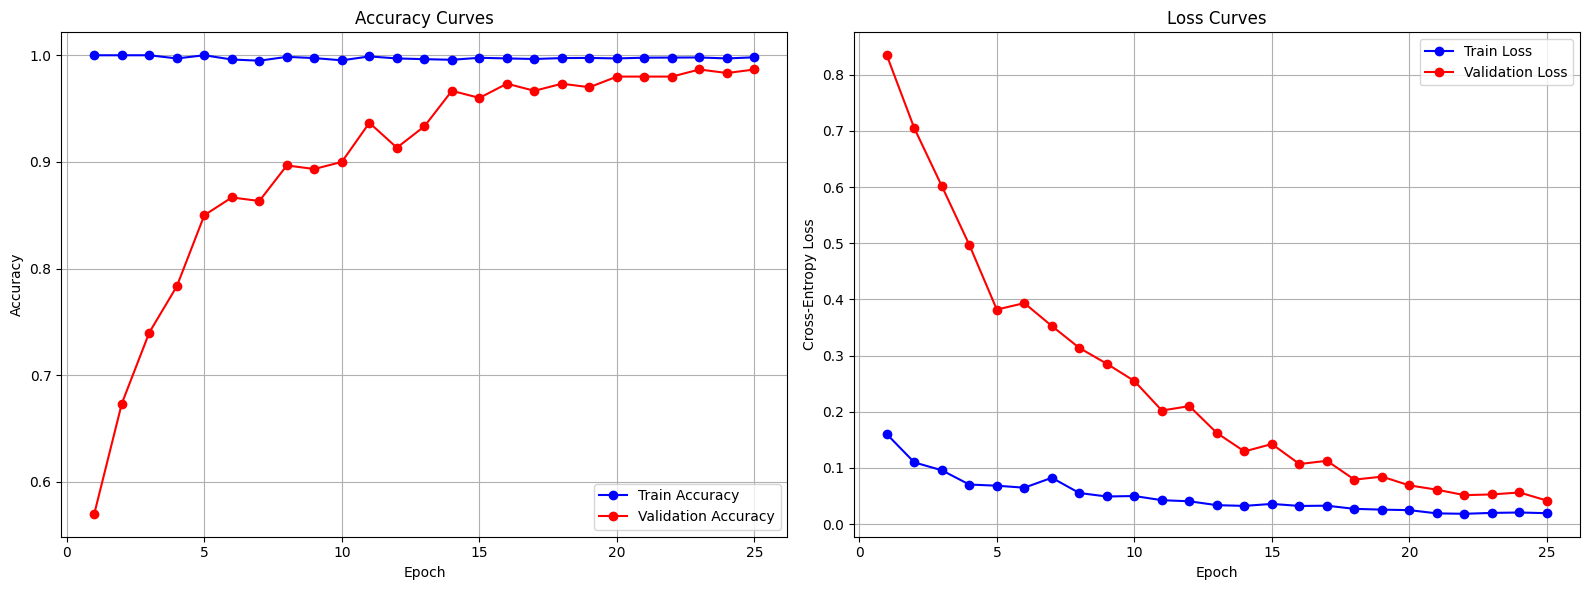

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Check and adjust lengths if necessary
min_length = min(len(train_acc), len(val_acc), len(train_losses), len(val_losses))

train_acc = train_acc[:min_length]
val_acc = val_acc[:min_length]
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]

# Save metrics to Excel
metrics_df = pd.DataFrame({
    'Epoch': range(1, min_length + 1),  # Ensure the 'Epoch' column matches the length
    'Train_Accuracy': train_acc,
    'Val_Accuracy': val_acc,
    'Train_Loss': train_losses,
    'Val_Loss': val_losses
})

save_dir = '/content/drive/MyDrive/Colab Notebooks/Hybrid/Dataset_BUSI_with_GT'
metrics_df.to_excel(f"{save_dir}/training_metrics.xlsx", index=False)

# Plot curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy plot
ax1.plot(metrics_df['Epoch'], metrics_df['Train_Accuracy'], 'b-o', label='Train Accuracy')
ax1.plot(metrics_df['Epoch'], metrics_df['Val_Accuracy'], 'r-o', label='Validation Accuracy')
ax1.set_title('Accuracy Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(metrics_df['Epoch'], metrics_df['Train_Loss'], 'b-o', label='Train Loss')
ax2.plot(metrics_df['Epoch'], metrics_df['Val_Loss'], 'r-o', label='Validation Loss')
ax2.set_title('Loss Curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Cross-Entropy Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(f"{save_dir}/loss_accuracy_plot.png", dpi=300, bbox_inches='tight')
plt.show()


In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

predictions = svm.predict(ts_feats)

acc = accuracy_score(ts_labels, predictions)
print(f"Test Set Accuracy: {acc:.4f}")

print("\nClassification Report:\n", classification_report(ts_labels, predictions, target_names=dataset.classes))

conf_mat = confusion_matrix(ts_labels, predictions)
print("\nConfusion Matrix:\n", conf_mat)


Test Set Accuracy: 0.9883

Classification Report:
               precision    recall  f1-score   support

      benign       0.98      0.98      0.98       192
   malignant       0.98      0.99      0.98       206
      normal       1.00      1.00      1.00       202

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600


Confusion Matrix:
 [[188   4   0]
 [  3 203   0]
 [  0   0 202]]


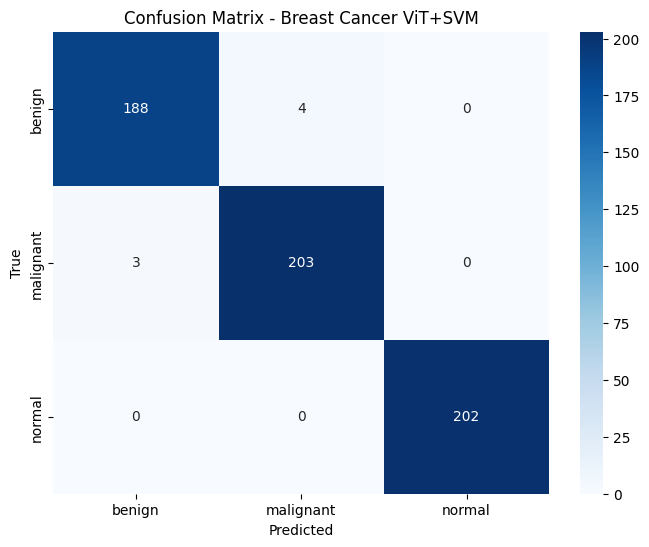

In [8]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Breast Cancer ViT+SVM')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Hybrid/Dataset_BUSI_with_GT/confusion_matrix.png', dpi=300)
plt.show()


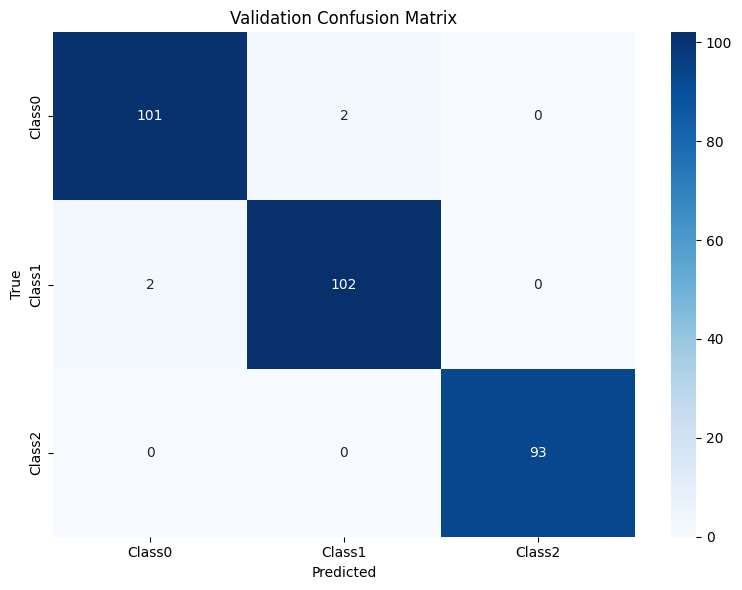

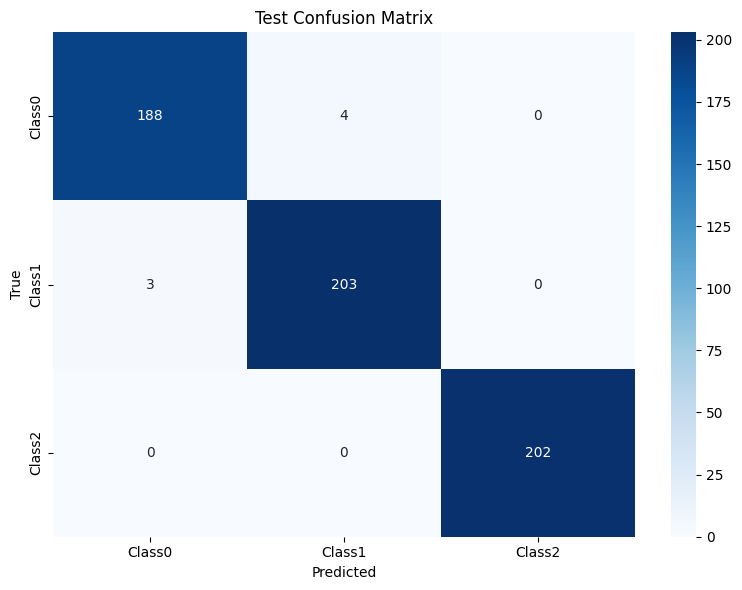

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import joblib

# Load SVM model
save_dir = '/content/drive/MyDrive/Colab Notebooks/Hybrid/Dataset_BUSI_with_GT'
svm = joblib.load(f"{save_dir}/svm_model_vit_ovr.pkl")

# Predictions
val_pred = svm.predict(val_feats)
ts_pred = svm.predict(ts_feats)

# Define your class names (replace below accordingly)
# Example:
# classes = {0: 'Benign', 1: 'Malignant', 2: 'Normal'}
classes = {0: 'Class0', 1: 'Class1', 2: 'Class2'}  # <-- Change this as per your labels

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, pred_labels, title, save_path):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(classes.values()),
                yticklabels=list(classes.values()))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Plot and save confusion matrices
plot_confusion_matrix(val_labels, val_pred,
                      "Validation Confusion Matrix",
                      f"{save_dir}/val_confusion_matrix.png")

plot_confusion_matrix(ts_labels, ts_pred,
                      "Test Confusion Matrix",
                      f"{save_dir}/test_confusion_matrix.png")


In [10]:
import pandas as pd
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np

# Define your classes here (if not already defined)
# Example:
# classes = {0: 'Benign', 1: 'Malignant', 2: 'Normal'}
classes = {0: 'Class0', 1: 'Class1', 2: 'Class2'}  # <-- Change this according to your task

# Function to print metrics nicely
def print_metrics(y_true, y_pred, set_name):
    print(f"\n{'='*40}")
    print(f"{set_name.upper()} SET METRICS")
    print('='*40)
    print(f"Accuracy : {np.mean(y_pred == y_true):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(classes.values())))

# Save all metrics to Excel
metrics = {
    'Validation': {
        'Accuracy': np.mean(val_pred == val_labels),
        'F1': f1_score(val_labels, val_pred, average='weighted'),
        'Precision': precision_score(val_labels, val_pred, average='weighted'),
        'Recall': recall_score(val_labels, val_pred, average='weighted')
    },
    'Test': {
        'Accuracy': np.mean(ts_pred == ts_labels),
        'F1': f1_score(ts_labels, ts_pred, average='weighted'),
        'Precision': precision_score(ts_labels, ts_pred, average='weighted'),
        'Recall': recall_score(ts_labels, ts_pred, average='weighted')
    }
}

# Save metrics DataFrame
save_dir = '/content/drive/MyDrive/Colab Notebooks/Hybrid/Dataset_BUSI_with_GT'
metrics_path = f"{save_dir}/final_metrics.xlsx"
pd.DataFrame(metrics).T.to_excel(metrics_path)

# Print reports
print_metrics(val_labels, val_pred, "Validation")
print_metrics(ts_labels, ts_pred, "Test")



VALIDATION SET METRICS
Accuracy : 0.9867
F1 Score : 0.9867
Precision: 0.9867
Recall   : 0.9867

Classification Report:
              precision    recall  f1-score   support

      Class0       0.98      0.98      0.98       103
      Class1       0.98      0.98      0.98       104
      Class2       1.00      1.00      1.00        93

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300


TEST SET METRICS
Accuracy : 0.9883
F1 Score : 0.9883
Precision: 0.9883
Recall   : 0.9883

Classification Report:
              precision    recall  f1-score   support

      Class0       0.98      0.98      0.98       192
      Class1       0.98      0.99      0.98       206
      Class2       1.00      1.00      1.00       202

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



In [13]:
# import random
# import matplotlib.pyplot as plt
# import torch
# import numpy as np
# from sklearn.svm import SVC

# # Denormalize class to convert tensor back to image
# class Denormalize:
#     def __init__(self, mean, std):
#         self.mean = torch.tensor(mean).view(-1, 1, 1)
#         self.std = torch.tensor(std).view(-1, 1, 1)

#     def __call__(self, tensor):
#         return tensor * self.std + self.mean

# # Configuration
# num_samples = 9  # 3x3 grid
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# denorm = Denormalize(mean, std)

# # Create figure
# plt.figure(figsize=(12, 12))

# # Get test dataset (from torch.utils.data.random_split)
# test_dataset = ts_dl.dataset
# indices = random.sample(range(len(test_dataset)), num_samples)

# for idx, sample_idx in enumerate(indices, 1):
#     # Load image and true label
#     img_tensor, true_label = test_dataset[sample_idx]

#     # Prepare image for visualization
#     img_vis = denorm(img_tensor.clone()).permute(1, 2, 0).cpu().numpy()
#     img_vis = np.clip(img_vis, 0, 1)

#     # Extract features and predict
#     with torch.no_grad():
#         feat = vit_model.extract_features(img_tensor.unsqueeze(0).to(device))
#         pred_label = svm.predict(feat.cpu().numpy())[0]

#     # Decode class names
#     true_class = list(classes.keys())[true_label]
#     pred_class = list(classes.keys())[pred_label]

#     # Display image
#     plt.subplot(3, 3, idx)
#     plt.imshow(img_vis)
#     plt.title(f"True: {true_class}\nPred: {pred_class}",
#               color='green' if true_label == pred_label else 'red',
#               fontsize=10)
#     plt.axis('off')

# plt.suptitle("Random Test Samples with Predictions", y=1.02, fontsize=16)
# plt.tight_layout()
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/Hybrid/Dataset_BUSI_with_GT/acVspred.png", bbox_inches='tight', dpi=300)
# plt.show()

In [11]:
# import os
# import shutil

# # Specify the folder path on your Google Drive
# folder_path = "/content/drive/MyDrive/Colab Notebooks/Hybrid/Dataset_BUSI_with_GT"

# # List all files in the directory and remove them
# for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)
#     if os.path.isfile(file_path):  # Check if it's a file (not a directory)
#         os.remove(file_path)
#         print(f"Removed file: {file_path}")

# print("All files have been deleted in the folder.")
